In [7]:
import sys
import torch
import ot

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../lib")
from distributions import sampleWrappedNormal
from utils_hyperbolic import *
from hsw import hyper_sliced_wasserstein
from hhsw import horo_hyper_sliced_wasserstein_lorentz, horo_hyper_sliced_wasserstein_poincare
from sw import sliced_wasserstein
from utility import *
from mmd import mmd, imq

import torch.nn as nn
import torch.optim as optim
from scipy.spatial import distance
from scipy.stats import pearsonr


device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
def BDP(depth=6, bf=2, dim=50, seed=555, ns=50):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    n1 = bf**(depth)-1
    X = torch.zeros((n1,dim))
    Y = torch.zeros((n1*ns,dim))
    Z = np.zeros(n1,dtype=int)
    
    for i in range(depth):
        for j in range(bf**i):
            if i == 0:
                X[j,:] = 0
            else:
                X[bf**i+j-1,:] = torch.randn(dim) + X[int(bf**(i-1))-1+int(j/bf),:]
                Z[bf**i+j-1] = int(bf**(i-1))-1+int(j/bf)

    for k in range(n1):
        Y[ns*k:(k+1)*ns] = torch.randn((ns,dim))/3 + X[k,:]

    return X, Y, Z



class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, poincare_output):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.poincare_output = poincare_output
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        if self.poincare_output:
            return exp0_poincare(x)
        else:
            return x

class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, poincare_output):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.poincare_output = poincare_output
    
    def forward(self, x):
        if self.poincare_output:
            x = log0_poincare(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [9]:
input_dim = 50
hidden_dim = 200
output_dim = 2
lamb = 0.05
num_epochs = 5000
models = ["SFW","IPRSFW(geo)","IPRSFW(horo)","MMD"]
corr = np.zeros(4)
X_test = [None]*4
X_true_encode = [None]*4

In [11]:
for m in range(4):

    poincare_output = True
    model = models[m]
    if model=="MMD":
        poincare_output = False
    X_true, train_dataset, Z = BDP()
    train_dataset = train_dataset.to(device)
    train_targets = train_dataset.clone().to(device)
    n_samples = train_dataset.shape[0]


    encoder = Encoder(input_dim, hidden_dim, output_dim, poincare_output).to(device)
    decoder = Decoder(output_dim, hidden_dim, input_dim, poincare_output).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


    # Training loop
    for epoch in range(num_epochs):

        optimizer.zero_grad()
        encoded = encoder(train_dataset)
        decoded = decoder(encoded)

        if poincare_output and model=="SFW":
            mu = torch.zeros(output_dim+1, dtype=torch.float64, device=device)
            mu[0] = 1
            Sigma = torch.eye(output_dim, dtype=torch.float, device=device)
            sample = lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, n_samples)).type(torch.FloatTensor).to(device)
            loss = criterion(decoded, train_targets) + lamb * SFW(sample, encoded, hyperbolic_model="Poincare", spf_curve='Hm_p')
            # loss = criterion(decoded, train_targets) + lamb * horo_hyper_sliced_wasserstein_poincare(sample, encoded, 500, device)
            
        elif poincare_output and model=="IPRSFW(geo)":
            mu = torch.zeros(output_dim+1, dtype=torch.float64, device=device)
            mu[0] = 1
            Sigma = torch.eye(output_dim, dtype=torch.float, device=device)
            sample = lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, n_samples)).type(torch.FloatTensor).to(device)
            loss = criterion(decoded, train_targets) + lamb * IPRSFW(sample, encoded, hyperbolic_model="Poincare", spf_curve='Hm_p', projection_kind="geodesic", q=2, nslice=5, p=2, eps=1e-5, device=device)

        elif poincare_output and model=="IPRSFW(horo)":
            mu = torch.zeros(output_dim+1, dtype=torch.float64, device=device)
            mu[0] = 1
            Sigma = torch.eye(output_dim, dtype=torch.float, device=device)
            sample = lorentz_to_poincare(sampleWrappedNormal(mu, Sigma, n_samples)).type(torch.FloatTensor).to(device)
            loss = criterion(decoded, train_targets) + lamb * IPRSFW(sample, encoded, hyperbolic_model="Poincare", spf_curve='Hm_p', projection_kind="horospherical", q=2, nslice=5, p=2, eps=1e-5, device=device)

        else:
            sample = torch.randn((n_samples,output_dim)).to(device)
            loss = criterion(decoded, train_targets) + lamb * mmd(sample, encoded, imq, 2*output_dim)
            # gen = torch.Generator(device=device)
            # gen.manual_seed(42)
            # loss = criterion(decoded, train_targets) + lamb * ot.sliced_wasserstein_distance(sample, encoded, n_projections=500, seed=gen)

        loss.backward()
        optimizer.step()
    


    X_test[m] = encoded.detach().cpu().numpy()
    X_true_encode[m] = encoder(X_true.to(device)).detach().cpu().numpy()
        

    dist1 = distance.cdist(train_dataset.cpu(), train_dataset.cpu(), 'euclidean')
    if poincare_output:
        dist2 = dist_poincare2(encoded.detach().cpu(), encoded.detach().cpu())
    else:
        dist2 = distance.cdist(encoded.detach().cpu().numpy(), encoded.detach().cpu().numpy(), 'euclidean')

    k = 0
    s1 = np.zeros(int(dist1.shape[0]*(dist1.shape[0]-1)/2))
    s2 = np.zeros(int(dist1.shape[0]*(dist1.shape[0]-1)/2))
    for i in range(dist1.shape[0]-1):
        for j in range(i+1,dist1.shape[0]):
            s1[k] = dist1[i,j]
            s2[k] = dist2[i,j]
            k = k+1

    corr[m] = pearsonr(s1, s2)[0]


Text(0.5, 1.0, 'WAE [cor=0.7625]')

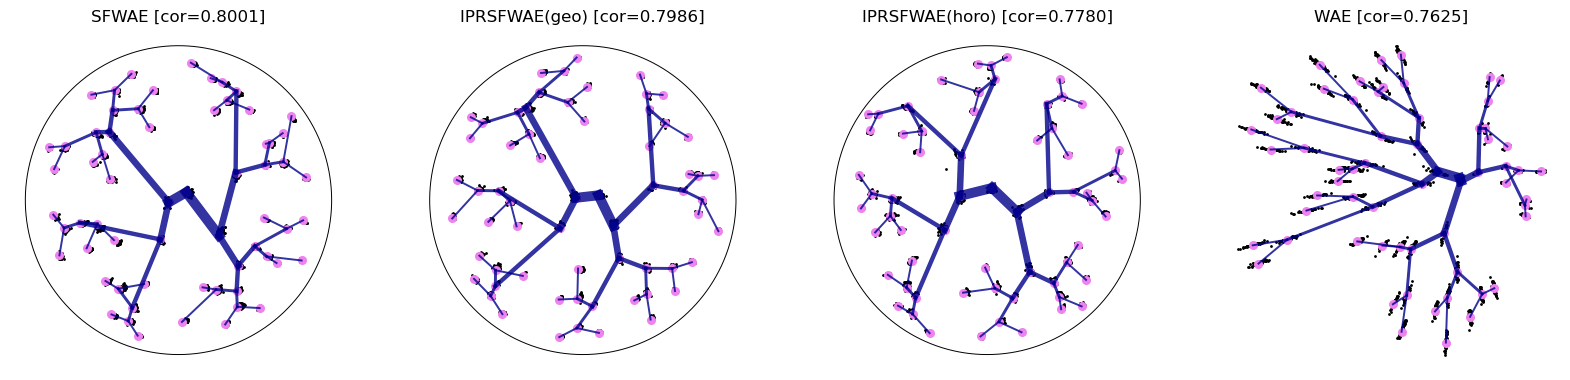

In [20]:
plt.figure(figsize=(20,4.5),dpi=100)


plt.subplot(1,4,1)
k = 0
plt.scatter(X_test[k][:,0], X_test[k][:,1], s=1, c="k", marker="o")
plt.scatter(X_true_encode[k][:,0], X_true_encode[k][:,1], s=30, marker="o", c="violet")
ss = np.arange(0,1000,1)
plt.plot(np.cos(ss*np.pi*2/1000),np.sin(ss*np.pi*2/1000),c="k",linewidth=0.7)
lw = (1/1.5)**np.arange(1,7)*16
for i in range(1,6):
    for j in range(2**i):
        x1 = X_true_encode[k][Z[2**i-1+j],0]
        x1_ = X_true_encode[k][Z[2**i-1+j],1]
        x2 = X_true_encode[k][2**(i)-1+j,0]
        x2_ = X_true_encode[k][2**(i)-1+j,1]
        plt.plot(np.array([x1,x2]),np.array([x1_,x2_]),linewidth=lw[i],c="darkblue",alpha=0.8)
plt.axis('off')
plt.title("SFWAE [cor={:.4f}]".format(corr[k]))



plt.subplot(1,4,2)
k = 1
plt.scatter(X_test[k][:,0], X_test[k][:,1], s=1, c="k", marker="o")
plt.scatter(X_true_encode[k][:,0], X_true_encode[k][:,1], s=30, marker="o", c="violet")
ss = np.arange(0,1000,1)
plt.plot(np.cos(ss*np.pi*2/1000),np.sin(ss*np.pi*2/1000),c="k",linewidth=0.7)
lw = (1/1.5)**np.arange(1,7)*16
for i in range(1,6):
    for j in range(2**i):
        x1 = X_true_encode[k][Z[2**i-1+j],0]
        x1_ = X_true_encode[k][Z[2**i-1+j],1]
        x2 = X_true_encode[k][2**(i)-1+j,0]
        x2_ = X_true_encode[k][2**(i)-1+j,1]
        plt.plot(np.array([x1,x2]),np.array([x1_,x2_]),linewidth=lw[i],c="darkblue",alpha=0.8)
plt.axis('off')
plt.title("IPRSFWAE(geo) [cor={:.4f}]".format(corr[k]))



plt.subplot(1,4,3)
k = 2
plt.scatter(X_test[k][:,0], X_test[k][:,1], s=1, c="k", marker="o")
plt.scatter(X_true_encode[k][:,0], X_true_encode[k][:,1], s=30, marker="o", c="violet")
ss = np.arange(0,1000,1)
plt.plot(np.cos(ss*np.pi*2/1000),np.sin(ss*np.pi*2/1000),c="k",linewidth=0.7)
lw = (1/1.5)**np.arange(1,7)*16
for i in range(1,6):
    for j in range(2**i):
        x1 = X_true_encode[k][Z[2**i-1+j],0]
        x1_ = X_true_encode[k][Z[2**i-1+j],1]
        x2 = X_true_encode[k][2**(i)-1+j,0]
        x2_ = X_true_encode[k][2**(i)-1+j,1]
        plt.plot(np.array([x1,x2]),np.array([x1_,x2_]),linewidth=lw[i],c="darkblue",alpha=0.8)
plt.axis('off')
plt.title("IPRSFWAE(horo) [cor={:.4f}]".format(corr[k]))



plt.subplot(1,4,4)
k = 3
plt.scatter(X_test[k][:,0], X_test[k][:,1], s=1, c="k", marker="o")
plt.scatter(X_true_encode[k][:,0], X_true_encode[k][:,1], s=30, marker="o", c="violet")
lw = (1/1.5)**np.arange(1,7)*16
for i in range(1,6):
    for j in range(2**i):
        x1 = X_true_encode[k][Z[2**i-1+j],0]
        x1_ = X_true_encode[k][Z[2**i-1+j],1]
        x2 = X_true_encode[k][2**(i)-1+j,0]
        x2_ = X_true_encode[k][2**(i)-1+j,1]
        plt.plot(np.array([x1,x2]),np.array([x1_,x2_]),linewidth=lw[i],c="darkblue",alpha=0.8)
plt.axis('off')
plt.title("WAE [cor={:.4f}]".format(corr[k]))
